# Overview
- nb022の改良
- mixupのハイパラチューニング
- top8を除く
- ctrlを除く

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

21549ec


# Const

In [2]:
# basic
NB = '026'
DEBUG = False 
isPI = False
isShowLog = False
MIXUP = True

PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'
PATH_DRUGID = '../data_ignore/input/train_drug.csv'
PATH_GROUP696 = './../data_ignore/output_nb/nb004/group.csv'
PATH_ESTIMATED_LOGLOSS = './../data_ignore/output_nb/nb017/estimated_logloss.csv'
TOP8_DRUG = ['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b', '292ab2c28', 'd50f18348', 'd1b47f29d']

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 80

dataset:
  name: 
  params:
    
split:
  name: MultiStratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: SmoothLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from glob import glob
from pdb import set_trace as st
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, _X_valid, y_valid):
        X_valid = pd.DataFrame(_X_valid, columns=FEAT_COLUMNS)
        self.n_feat = len(X_valid.columns)
        
        val_set = MoaDataset(_X_valid, y_valid, mode='train')
        dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
        y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
        
        
        self.base_score = self.metric(y_valid, y_valid_pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(progress_bar(X_valid.columns)):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            
#             y_valid_pred = self.model.predict(df_perm)
            val_set = MoaDataset(df_perm.values, y_valid, mode='train')
            dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
            y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
            
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

def get_not_drug_leak_folds(n_splits, train_features, train_drug, gruoup696):
    '''
    n_splits だけfoldを作成する。
    ただし、cp_type = ctl_vehicle と、top8にはfold=-1を割り振っている。
    
    696group のcsv: https://www.kaggle.com/fkubota/moa-nb004-696group
    
    ::example::
    train_features = pd.read_csv("train_features.csv")
    train_drug = pd.read_csv("train_drug.csv")
    group696 = pd.read_csv("MoA_nb004_696group/group.csv")
    df_fold = get_not_drug_leak_folds(5, train_features, train_drug, group696)
    '''
    TOP8_DRUG = ['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b', '292ab2c28', 'd50f18348', 'd1b47f29d']
    mask_trt = (train_features['cp_type'] == 'trt_cp').values

    # mask_top8 を作成
    mask_top8 = []
    for drug_id in train_drug.drug_id.values:
        if drug_id in TOP8_DRUG:
            mask_top8.append(True)
        else:
            mask_top8.append(False)
    mask_top8 = np.array(mask_top8)
    
    # trt かつ top8 以外を抜き出す
    # group = 0 は要素数が多いので一番最後にやるようにする
    drug_groups = group696[mask_trt & ~mask_top8].group.values
    groups = np.sort(group696[mask_trt & ~mask_top8].group.unique())
    groups = groups[1:]
    groups = np.append(groups, 0)
    
    # 各グループにfoldを割り振る
    tile = []
    train_drug_trt = train_drug[mask_trt & ~mask_top8]
    train_drug_trt['fold'] = -1
    for i_grp, grp in enumerate(groups):
        if i_grp == 0:
            tile = np.arange(1, n_splits+1).astype(int)

        mask_grp = drug_groups == grp
        drug_rank = train_drug[mask_trt & ~mask_top8][mask_grp].drug_id.value_counts()

        n_repeat = np.ceil(len(drug_rank)/n_splits).astype(int)
        folds = np.tile(tile, n_repeat)[:len(drug_rank)]

        for i, drug_id in enumerate(drug_rank.index.sort_values()):
            mask = train_drug_trt.drug_id.values == drug_id
            train_drug_trt.fold[mask] = folds[i]
        tile = train_drug_trt.fold.value_counts()[::-1][:n_splits].index
        
    train_drug_fold = train_drug.copy()
    train_drug_fold['fold'] = -1
    train_drug_fold['fold'][mask_trt & ~mask_top8] = train_drug_trt.fold.values
    return train_drug_fold

In [7]:
class MoaModel(nn.Module):
    def __init__(self, n_input, n_output):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(n_input)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_input, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, n_output))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x_raw = self.dense3(x)
        x_sigmoid = F.sigmoid(x_raw)
        
        return x_sigmoid, x_raw

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [9]:
def mean_log_loss(y_true, y_pred):
    metrics = []
#     for i in range(y_true.shape[1]):
#         metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
#     return np.mean(metrics)
    y_true =  y_true.astype(np.float64).ravel()
    y_pred =  y_pred.astype(np.float64).ravel()
    return log_loss(y_true, y_pred, labels=[0, 1])

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.001):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

class FocalLoss2d(nn.modules.loss._WeightedLoss):
    '''
    https://github.com/andrijdavid/FocalLoss/blob/master/focalloss.py
    '''
    def __init__(self, gamma=2, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean', balance_param=0.25):
        super(FocalLoss2d, self).__init__(weight, size_average, reduce, reduction)
        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
        
        weight = Variable(self.weight)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target, pos_weight=self.weight, reduction=self.reduction)
#         logpt = - F.binary_cross_entropy_with_logits(input, target, reduction=self.reduction)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         if not DEBUG:
        torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion, mixup=False, mixup_alpha=1):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        if mixup:
            x, y_a, y_b, lam = mixup_data(x, y, mixup_alpha)
            
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            pred_sigmoid, pred_raw = model(x)
            if mixup:
                loss = mixup_criterion(criterion, pred_raw, y_a, y_b, lam)
            else:
                loss = criterion(pred_raw, y)

            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

def get_epoch_pred(model, device, valid_loader):
    model.eval()
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    return preds

In [12]:
def run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=True, mixup=False, mixup_alpha=1):
    device = torch.device("cuda")
    model = ModelClass(shape[0], shape[1]).to(device)
#     model = ModelClass(train.shape[1], ).to(device)
    early_stopping = EarlyStopping(patience=15, verbose=show_log, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion, mixup=mixup, mixup_alpha=mixup_alpha)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion, optimizer)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        if show_log:
            print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds
    return best_mean_log_loss, best_preds, trn_losses, val_losses

def run(splitter, train, targets, ModelClass, show_log=True, pi=False, mixup=False):
    mean_log_loss_list = []
    oof = np.zeros_like(targets).astype(float)
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
        print('-'*100)
        print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
        print('-'*100)
        X_trn, X_val = train[idx_trn], train[idx_val]
        y_trn, y_val = targets[idx_trn], targets[idx_val]

        train_set = MoaDataset(X_trn, y_trn, mode='train')
        val_set = MoaDataset(X_val, y_val, mode='train')

        dataloaders = {
            'train': DataLoader(train_set, **settings['loader']['train']),
            'val': DataLoader(val_set, **settings['loader']['val']),
        }

        checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
        shape = (X_trn.shape[1], y_trn.shape[1])
        best_mean_log_loss, best_preds, trn_losses, val_losses =  run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=show_log, mixup=mixup)

        # result
        print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
        mean_log_loss_list.append(best_mean_log_loss)
        oof[idx_val, :] = best_preds
        
        # permutation importance
        if pi:
            device = torch.device("cuda")
            model = ModelClass(shape[0], shape[1]).to(device)
            state_dict = torch.load(checkpoint_path)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            pi = permutation_importance(model, mean_log_loss) # model と metric を渡す
            pi.compute(X_val, y_val)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
    #         pi.show_permutation_importance(score_type='loss')
        
        # plot
        if show_log:
            x = np.arange(1, len(trn_losses)+1)
            plt.figure(figsize=(12, 7))
            plt.plot(x[1:], trn_losses[1:], '--.', label='train')
            plt.plot(x[1:], val_losses[1:], '--.', label='valid')
            plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
            plt.legend()
            plt.show()
        print('\n')
    
    if pi:
        # permutation score
        plt.figure(figsize=(15, int(0.25*len(FEAT_COLUMNS))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=True)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()
    return mean_log_loss_list, oof, df_pi

def run_not_drug_leak(df_fold, train, targets, ModelClass, show_log=True, pi=False, mixup=False, mixup_alpha=1):
    mean_log_loss_list = []
    oof = np.zeros_like(targets).astype(float)
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
#     for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
    for n, fold_i in enumerate(df_fold['fold'].unique()):
        print('-'*100)
        print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
        print('-'*100)
        mask_fold = df_fold.fold == fold_i
        X_trn, X_val = train[~mask_fold], train[mask_fold]
        y_trn, y_val = targets[~mask_fold], targets[mask_fold]

        train_set = MoaDataset(X_trn, y_trn, mode='train')
        val_set = MoaDataset(X_val, y_val, mode='train')

        dataloaders = {
            'train': DataLoader(train_set, **settings['loader']['train']),
            'val': DataLoader(val_set, **settings['loader']['val']),
        }

        checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
        shape = (X_trn.shape[1], y_trn.shape[1])
        best_mean_log_loss, best_preds, trn_losses, val_losses = run_fold(dataloaders, shape, checkpoint_path, 
                                                                          ModelClass, show_log=show_log, 
                                                                          mixup=mixup, mixup_alpha=mixup_alpha)

        # result
        print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
        mean_log_loss_list.append(best_mean_log_loss)
#         oof[idx_val, :] = best_preds
        oof[mask_fold, :] = best_preds
        
        # permutation importance
        if pi:
            device = torch.device("cuda")
            model = ModelClass(shape[0], shape[1]).to(device)
            state_dict = torch.load(checkpoint_path)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            pi = permutation_importance(model, mean_log_loss) # model と metric を渡す
            pi.compute(X_val, y_val)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
    #         pi.show_permutation_importance(score_type='loss')
        
        # plot
        if show_log:
            x = np.arange(1, len(trn_losses)+1)
            plt.figure(figsize=(12, 7))
            plt.plot(x[1:], trn_losses[1:], '--.', label='train')
            plt.plot(x[1:], val_losses[1:], '--.', label='valid')
            plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
            plt.legend()
            plt.show()
        print('\n')
    
    if pi:
        # permutation score
        plt.figure(figsize=(15, int(0.25*len(FEAT_COLUMNS))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=True)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()
    return mean_log_loss_list, oof, df_pi

# Preparation

set

In [13]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
sns.set_context('talk')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [14]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [15]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# test_features = pd.read_csv(PATH_TEST)
train_drug = pd.read_csv(PATH_DRUGID)
group696 = pd.read_csv(PATH_GROUP696)

# ss = pd.read_csv(PATH_SUB)

In [16]:
# mask_top8 を作成
mask_top8 = []
for drug_id in train_drug.drug_id.values:
    if drug_id in TOP8_DRUG:
        mask_top8.append(True)
    else:
        mask_top8.append(False)
mask_top8 = np.array(mask_top8)

In [17]:
end_col = 10
step_row = 11

if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::step_row, :end_col].reset_index(drop=True)
    train_targets = train_targets.iloc[::step_row, :].reset_index(drop=True)
    mask_top8 = mask_top8[::step_row]
    train_drug = train_drug.iloc[::step_row, :].reset_index(drop=True)
    group696 = group696.iloc[::step_row, :].reset_index(drop=True)
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [18]:
mask_trt = (train_features['cp_type'] == 'trt_cp').values
train = preprocess(train_features)
FEAT_COLUMNS = train_features.columns[2:]
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [19]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


<br>

fold分割

In [20]:
%%time
df_fold = get_not_drug_leak_folds(settings['split']['params']['n_splits'], train_features, train_drug, group696)

CPU times: user 6.53 s, sys: 0 ns, total: 6.53 s
Wall time: 6.53 s


In [21]:
splitter = KFold(n_splits=settings['split']['params']['n_splits'], random_state=1, shuffle=True)
for top8_i in range(len(TOP8_DRUG)):
    mask_drug = df_fold['drug_id'] == TOP8_DRUG[top8_i]

    for fold_i, (train_idx, valid_idx) in enumerate(splitter.split(df_fold[mask_drug])):
#         df_fold[['fold']][mask_drug].iloc[valid_idx, :] = fold_i + 1
#         df_fold[['fold']][mask_drug] = fold_i + 1
        _df_fold = df_fold[mask_drug]
        _df_fold.fold.values[valid_idx] = fold_i + 1
        df_fold.fold[mask_drug] = _df_fold.fold.values
print(df_fold.fold.unique())
print(df_fold[mask_trt].fold.unique())

[ 5  3  1  2  4 -1]
[5 3 1 2 4]


<br>

top8の除去

In [22]:
train = train[~mask_top8[mask_trt]]
targets = targets[~mask_top8[mask_trt]]
df_fold = df_fold[mask_trt & ~mask_top8].reset_index(drop=True)

# Create model

In [23]:
n_splits = settings['split']['params']['n_splits']
n_epochs = settings['globals']['num_epochs']
splitter = MultilabelStratifiedKFold(**settings['split']['params'])
device = settings['globals']['device']
# criterion = criterion_ = nn.__getattribute__(
#     settings['loss']['name'])(**settings['loss']['params'])
criterion = SmoothBCEwLogits(**settings['loss']['params'], smoothing=0)

In [27]:
# n_logspace = 5
n_logspace = 20
logspace = np.logspace(0, 1.3, n_logspace)
# logspace = np.hstack((np.array([0]), logspace))
logspace

array([ 1.        ,  1.17063378,  1.37038345,  1.60421716,  1.8779508 ,
        2.19839265,  2.5735127 ,  3.0126409 ,  3.52669921,  4.12847324,
        4.83293024,  5.6575914 ,  6.62296762,  7.75306963,  9.07600522,
       10.62467831, 12.43760735, 14.55988332, 17.04429127, 19.95262315])

In [28]:
%%time
# mean_log_loss_list, _oof, df_pi = run(splitter, train, targets, MoaModel, show_log=isShowLog, pi=isPI)
list_oof_score = []
for alpha in progress_bar(logspace):
    print(f'mixup_alpha: {alpha}')
    save_path = f'{SAVE_DIR}oof_focal_loss_mixup-alpha_{alpha:.6f}.csv'
    print(f'save: {save_path}')
    
    mean_log_loss_list, _oof, df_pi = run_not_drug_leak(df_fold, train, targets, MoaModel,
                                                        show_log=isShowLog, pi=isPI, 
                                                        mixup=MIXUP, mixup_alpha=alpha)
    oof_score = mean_log_loss(targets, _oof)
    list_oof_score.append(oof_score)
    
    # save oof
    df_oof = pd.DataFrame(_oof, columns=target_cols)
    df_oof.to_csv(save_path, index=False)

df_result = pd.DataFrame()
df_result['mixup_alpha'] = logspace
df_result['oof_score'] = list_oof_score

mixup_alpha: 1.0
save: ../data_ignore/output_nb/nb026/oof_focal_loss_mixup-alpha_1.000000.csv
----------------------------------------------------------------------------------------------------
:: start fold 1/5 at Fri Nov 27 10:00:28 2020 ::
----------------------------------------------------------------------------------------------------
Early stopping
:: best mean_log_loss: 0.01886 ::


----------------------------------------------------------------------------------------------------
:: start fold 2/5 at Fri Nov 27 10:01:59 2020 ::
----------------------------------------------------------------------------------------------------
Early stopping
:: best mean_log_loss: 0.02009 ::


----------------------------------------------------------------------------------------------------
:: start fold 3/5 at Fri Nov 27 10:03:26 2020 ::
----------------------------------------------------------------------------------------------------
Early stopping
:: best mean_log_loss: 0.01872 ::




NameError: name 'df_resultmma' is not defined

# Result

In [32]:
df_result

,mixup_alpha,oof_score
0,1.000000,0.019644
1,1.170634,0.019574
2,1.370383,0.019595
3,1.604217,0.019559
4,1.877951,0.019541
5,2.198393,0.019539
6,2.573513,0.019568
7,3.012641,0.019544
8,3.526699,0.019542
9,4.128473,0.019530


Text(0, 0.5, 'oof_score')

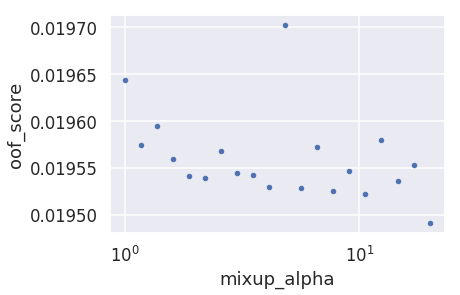

In [35]:
# plt.axhline(df_result.oof_score[0], color='r', label='mixup_alpha=1')
# plt.plot(df_result.mixup_alpha[1:], df_result.oof_score[1:], '.', label=None)
plt.plot(df_result.mixup_alpha, df_result.oof_score, '.', label=None)
plt.xscale('log')
plt.xlabel('mixup_alpha')
plt.ylabel('oof_score')
# plt.legend()